In [25]:
import sys
import os

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import yaml
import torch
import numpy as np

from dqn.opinion_dynamics.opinion_dqn import AgentDQN
from dqn.opinion_dynamics.utils.my_logging import setup_logger
from dqn.opinion_dynamics.utils.experiment import build_environment

from dynamic_programming.opinion_dynamics.common.viz import plot_opinions_over_time, visualize_policy_from_env


def instantiate_agent(exp_subdir_path: str) -> AgentDQN:
    """
    Instantiate an AgentDQN using the configuration stored in a YAML file 
    in the provided experiment subdirectory. The agent is created with the 
    given training and validation environments and loads its previous state.
    
    Args:
        exp_subdir_path (str): Path to the experiment subdirectory containing the config YAML and checkpoint files.

    
    Returns:
        AgentDQN: An instance of AgentDQN initialized using the experiment configuration and saved state.
    """
    # Assume the YAML configuration is stored as 'config.yaml' in the experiment folder.
    config_path = os.path.join(exp_subdir_path, "cfg.yaml")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at {config_path}")
    
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    
    # Instantiate the agent.
    # The resume_training_path is set to the experiment folder so that the agent loads saved weights/stats.
    agent = AgentDQN(
        resume_training_path=exp_subdir_path,
        experiment_name=config["experiment"],
        config=config,
        save_checkpoints=False,  # you can set this as needed
        logger=setup_logger("dqn")
    )
    
    return agent

def run_policy_agent(agent, max_steps=1000):
    """
    Run the simulation using the agent’s policy (exploitation only).
    
    Args:
        env: The environment (which must have a reset and step method).
        agent: An already-trained AgentDQN instance.
        max_steps: Maximum number of steps to run.
        
    Returns:
        opinions_over_time: Array of opinions (states) over time.
        time_points: Array of time stamps.
        rewards_over_time: Array of rewards collected at each step.
        actions_over_time: Array of actions taken at each step.
    """
    time_points = []
    rewards_over_time = []
    actions_over_time = []  # New: record the actions used.
    opinions_over_time = []
    env = agent.validation_env
    
    current_time = 0.0
    # Reset environment
    state, _ = env.reset()
    opinions_over_time.append(state.copy())
    
    for step in range(max_steps):
        # Convert state to a batched tensor (batch size = 1)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        # Use the agent in exploitation mode (epsilon=0, random_action=False)
        # The agent.select_action returns (action, beta_idx, q_value)
        action, _, _, _ = agent.select_action(state_tensor, epsilon=0.0, random_action=False)
        # action is returned as a NumPy array with shape (1, n_agents)
        action = np.squeeze(action)  # Now action has shape (n_agents,)
        actions_over_time.append(action.copy())
        
        # Apply the action in the environment.
        next_state, reward, done, truncated, _ = env.step(action, env.tau)
        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        time_points.append(current_time)
        
        current_time += env.tau
        state = next_state
        
        if done or truncated:
            print(f"Simulation ended at step {step}: done={done}, truncated={truncated}")
            break

    return (np.array(opinions_over_time),
            np.array(time_points),
            np.array(rewards_over_time),
            np.array(actions_over_time))

2025-05-05 19:32:26,114 - dqn - INFO - opinion_dqn.py:218 - Loaded configuration settings.
2025-05-05 19:32:26,118 - dqn - INFO - opinion_dqn.py:277 - Initialized networks and optimizer.
2025-05-05 19:32:29,724 - dqn - INFO - opinion_dqn.py:163 - Loaded previous training status from the following files: {'replay_buffer_file': 'D:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025May05-114705_configs\\0000_experiment_run_name_best_params\\5\\opinion_agent_dqn_replay_buffer', 'train_stats_file': 'D:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025May05-114705_configs\\0000_experiment_run_name_best_params\\5\\opinion_agent_dqn_train_stats', 'checkpoint_model_file': 'D:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025May05-114705_configs\\0000_experiment_run_name_best_params\\5\\model_checkpoints\\mck_20'}
Simulation ended at step 16: done=True, truncated=False


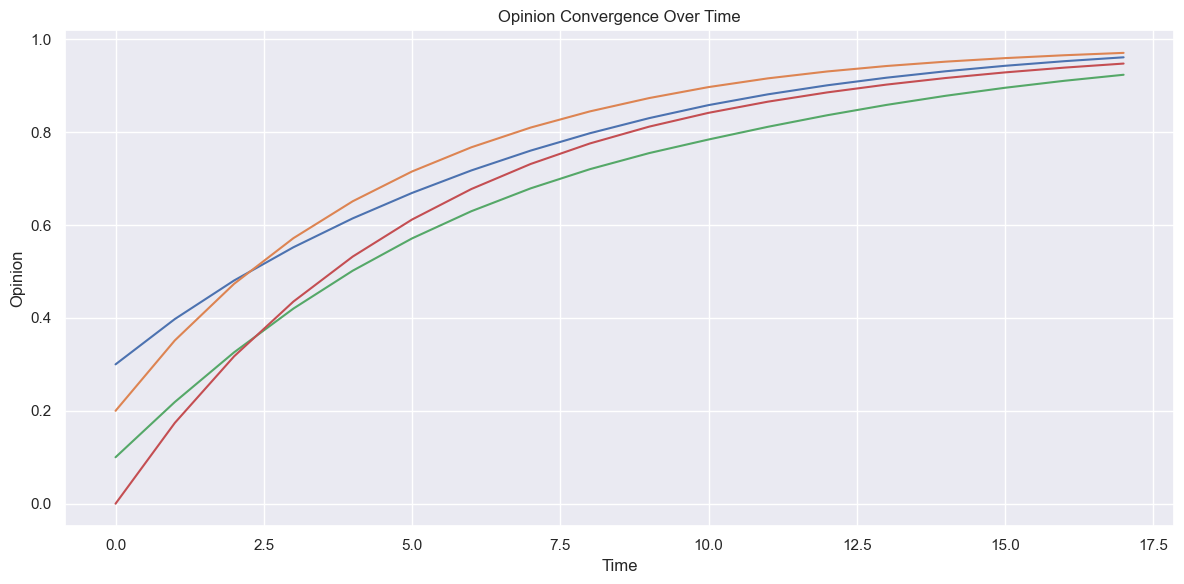

In [26]:
# best performing
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr22-104437_configs\0003_agent_params.args_.action_w_noise_amplitude_0.6\0"

# last run
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May02-101004_configs\0025_optim.args_.eps_1e-07__optim.args_.lr_1e-05__agent_params.args_.target_model_update_freq_500__agent_params.args_.training_freq_4__agent_params.args_.batch_size_32__agent_params.args_.action_w_noise_amplitude_0.3\1" # excellent run


exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May05-114705_configs\0000_experiment_run_name_best_params\5" 


agent = instantiate_agent(exp_subdir)

max_steps = 30
states, times, rewards, actions = run_policy_agent(agent, max_steps=max_steps)

plot_opinions_over_time(states)


In [27]:
len(actions)

17

In [28]:
actions

array([[0.16837268, 0.18215586, 0.09827487, 0.15119661],
       [0.1676815 , 0.18546236, 0.09322555, 0.15363064],
       [0.16771922, 0.18908332, 0.08766301, 0.15553448],
       [0.16914406, 0.19298737, 0.08103691, 0.15683168],
       [0.1728761 , 0.19618592, 0.07226399, 0.15867408],
       [0.17910516, 0.19941832, 0.06076511, 0.16071142],
       [0.18686323, 0.20297061, 0.04771044, 0.16245574],
       [0.19620907, 0.20685998, 0.03304952, 0.16388145],
       [0.20715976, 0.2111185 , 0.01669605, 0.16502574],
       [0.21918961, 0.21526833, 0.        , 0.1655421 ],
       [0.22475415, 0.21328564, 0.        , 0.16196018],
       [0.23112388, 0.2089255 , 0.        , 0.15995064],
       [0.23831634, 0.20252992, 0.        , 0.15915374],
       [0.24628171, 0.19544625, 0.        , 0.15827204],
       [0.2549446 , 0.18775745, 0.        , 0.157298  ],
       [0.26420057, 0.17956474, 0.        , 0.15623473],
       [0.2739204 , 0.17098658, 0.        , 0.15509307]], dtype=float32)

In [29]:
gamma = 0.9
total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r
    
total_value

-3.8854694348508896

In [30]:
sum(rewards)

-5.6280751098484645